### Configurations

In [1]:
# Import libraries
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
# Visualisation utilities

class PlotTraining(tf.keras.callbacks.Callback):
    def __init__(self,steps_per_epoch, sample_rate=1, zoom=1):
        self.sample_rate = sample_rate
        self.step = 0
        self.zoom = zoom
        self.steps_per_epoch = steps_per_epoch

    def on_train_begin(self, logs={}):
        self.batch_history = {}
        self.batch_step = []
        self.epoch_history = {}
        self.epoch_step = []
        self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
        plt.ioff()

    def on_batch_end(self, batch, logs={}):
        if (batch % self.sample_rate) == 0:
            self.batch_step.append(self.step)
            for k,v in logs.items():
                # do not log "batch" and "size" metrics that do not change
                # do not log training accuracy "acc"
                if k=='batch' or k=='size':# or k=='acc':
                    continue
                self.batch_history.setdefault(k, []).append(v)
        self.step += 1

    def on_epoch_end(self, epoch, logs={}):
        plt.close(self.fig)
        self.axes[0].cla()
        self.axes[1].cla()

        self.axes[0].set_ylim(0, 1.2/self.zoom)
#         self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
        self.axes[1].set_ylim(0, 1+0.1/self.zoom/2)

        self.epoch_step.append(self.step)
        for k,v in logs.items():
            # only log validation metrics
            if not k.startswith('val_'):
                continue
            self.epoch_history.setdefault(k, []).append(v)

        display.clear_output(wait=True)

        for k,v in self.batch_history.items():
            self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)

        for k,v in self.epoch_history.items():
            self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)

        self.axes[0].legend()
        self.axes[1].legend()
        self.axes[0].set_xlabel('epochs')
        self.axes[1].set_xlabel('epochs')
        self.axes[0].minorticks_on()
        self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
        self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
        self.axes[1].minorticks_on()
        self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
        self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
        display.display(self.fig)

In [3]:
# Import dataset 
header = ["id", "diagnosis", "radius_m", "texture_m", "perimeter_m", "area_m", "smoothness_m", "compact_m", "concavity_m", "concave_m", "symmetry_m", "fractal_m", "radius_std", "texture_std", "perimeter_std", "area_std", "smoothness_std", "compact_std", "concavity_std", "concave_std", "symmetry_std", "fractal_std", "radius_l", "texture_l", "perimeter_l", "area_l", "smoothness_l", "compact_l", "concavity_l", "concave_l", "symmetry_l", "fractal_l"]
df = pd.read_csv("../data/wdbc.data",header=None,
                names=header)
# df.describe()
# df.dtypes

# To view the data
df.head()

,id,diagnosis,radius_m,texture_m,perimeter_m,area_m,smoothness_m,compact_m,concavity_m,concave_m,...,radius_l,texture_l,perimeter_l,area_l,smoothness_l,compact_l,concavity_l,concave_l,symmetry_l,fractal_l
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
##################
# Preprocessing  #
##################
df_copy = df.copy()
labels = df_copy.pop('diagnosis')
labels[labels=='M']=1
labels[labels=='B']=0


In [14]:
#####################
# Hyper-parameters  #
#####################
BATCH_SIZE = 50
EPOCHS = 20
VALID_SPLIT = 0.3
STEPS_PER_EPOCH = (df.shape[0]*(1-VALID_SPLIT))//BATCH_SIZE


In [61]:
def testModel(seqModel, lossfunc):

    ########################
    # Summarize the model  #
    ########################
    seqModel.summary()
    tf.keras.utils.plot_model(seqModel,'model.png', show_shapes=True)

    
    ########################
    # Compile the model    #
    ########################
    seqModel.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4), 
                     loss=lossfunc, 
                     metrics=['accuracy'])

    #######################
    # Fit the model       #
    #######################
    # seqModel.fit(x=df_batches, epochs=EPOCHS)

    # X = df.iloc[:, 2:]
    # X = X.to_numpy()
    # Y = labels.to_numpy()
    # seqModel.fit(x=X.astype(np.float32), y=Y.astype(np.float32), epochs=EPOCHS, validation_split=0.3

    X = tf.convert_to_tensor(df.iloc[:, 2:].to_numpy())
    Y = tf.convert_to_tensor(labels)

    # Utility callback that displays training curves
    plot_training = PlotTraining(STEPS_PER_EPOCH, sample_rate=2, zoom=1)
#     reg_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

    seqModel.fit(x=X, y=Y, epochs=EPOCHS, batch_size= BATCH_SIZE, validation_split=VALID_SPLIT, callbacks=[plot_training])

***
### Start of experiments

BinaryCrossEntropy

Dense(1)

Sigmoid

# $S(x)=\frac{1}{1+e^{-x}}=\frac{e^{x}}{e^{x}+1}$
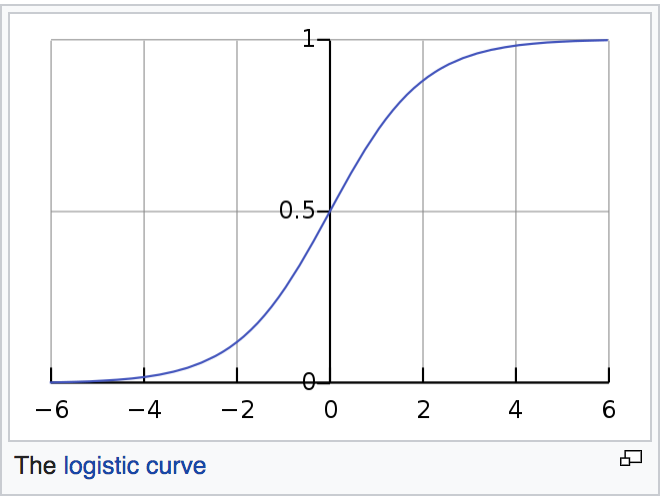

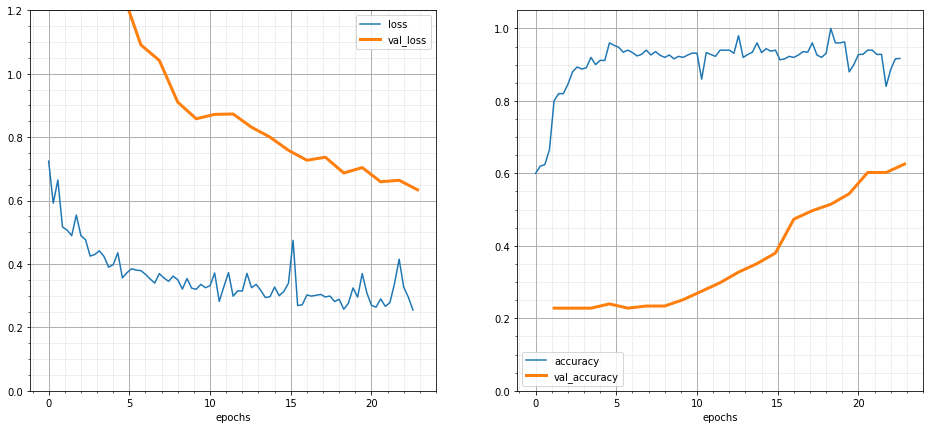

398/398 [==============================] - 0s 1ms/sample - loss: 0.3065 - accuracy: 0.9171 - val_loss: 0.6338 - val_accuracy: 0.6257


In [62]:
lossFunc = tf.keras.losses.BinaryCrossentropy()

seqModel = tf.keras.Sequential(
[#featureLayer,
 tf.keras.layers.Input(shape=(30,)),
 tf.keras.layers.Dense(100),
 tf.keras.layers.Activation('relu'),    
 
 tf.keras.layers.Dense(60),
 tf.keras.layers.BatchNormalization(scale=False, center=True),
 tf.keras.layers.Activation('relu'),
 
 tf.keras.layers.Dense(50),
 tf.keras.layers.BatchNormalization(scale=False, center=True),
 tf.keras.layers.Activation('relu'),
 
 tf.keras.layers.Dense(10),
 tf.keras.layers.BatchNormalization(scale=False, center=True),
 tf.keras.layers.Activation('relu'),
 
 tf.keras.layers.Dense(1, activation='sigmoid')
]
)

testModel(seqModel, lossFunc)

## Everything works. Lets try to change some stuff
***
### Will it work it we change our last layer activation to the well known softmax?

BinaryCrossEntropy

Dense(1)

# Softmax

# $S\left(y_{i}\right)=\frac{e^{y_{i}}}{\sum_{j} e^{y_{j}}}$

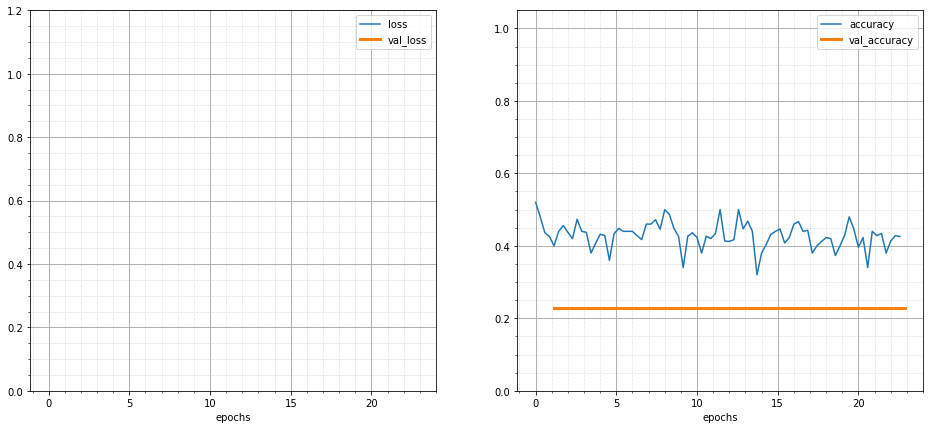

398/398 [==============================] - 1s 1ms/sample - loss: 8.6208 - accuracy: 0.4347 - val_loss: 11.7713 - val_accuracy: 0.2281


In [63]:
lossFunc = tf.keras.losses.BinaryCrossentropy()

seqModel = tf.keras.Sequential(
[#featureLayer,
 tf.keras.layers.Input(shape=(30,)),
 tf.keras.layers.Dense(100),
 tf.keras.layers.Activation('relu'),    
 
 tf.keras.layers.Dense(60),
 tf.keras.layers.BatchNormalization(scale=False, center=True),
 tf.keras.layers.Activation('relu'),
 
 tf.keras.layers.Dense(50),
 tf.keras.layers.BatchNormalization(scale=False, center=True),
 tf.keras.layers.Activation('relu'),
 
 tf.keras.layers.Dense(10),
 tf.keras.layers.BatchNormalization(scale=False, center=True),
 tf.keras.layers.Activation('relu'),
 
 tf.keras.layers.Dense(1, activation='softmax')
]
)

testModel(seqModel, lossFunc)

### It wont work, we only have 1 neural output for our last layer
Lets change that

***

BinaryCrossEntropy

# Dense(2)

Softmax

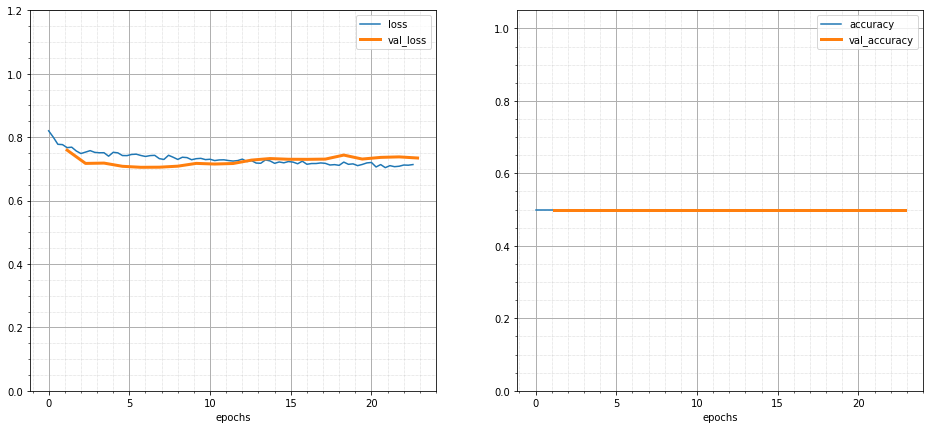

398/398 [==============================] - 1s 1ms/sample - loss: 0.7114 - accuracy: 0.5000 - val_loss: 0.7341 - val_accuracy: 0.5000


In [66]:
lossFunc = tf.keras.losses.BinaryCrossentropy()

seqModel = tf.keras.Sequential(
[#featureLayer,
 tf.keras.layers.Input(shape=(30,)),
 tf.keras.layers.Dense(100),
 tf.keras.layers.Activation('relu'),    
 
 tf.keras.layers.Dense(60),
 tf.keras.layers.BatchNormalization(scale=False, center=True),
 tf.keras.layers.Activation('relu'),
 
 tf.keras.layers.Dense(50),
 tf.keras.layers.BatchNormalization(scale=False, center=True),
 tf.keras.layers.Activation('relu'),
 
 tf.keras.layers.Dense(10),
 tf.keras.layers.BatchNormalization(scale=False, center=True),
 tf.keras.layers.Activation('relu'),
 
 tf.keras.layers.Dense(2, activation='softmax')
]
)

testModel(seqModel, lossFunc)

### Hmmm, whats the actual problem? 
Lets check our loss function...

CrossEntropy: 
$C E=-\sum_{i} t_{i} \log \left(s_{i}\right)$

BinaryCrossEntropy:
$ -t_{1} \log \left(s_{1}\right)-\left(1-t_{1}\right) \log \left(1-s_{1}\right)$

### Lets change our loss function
***

# CategoricalCrossEntropy

Dense(2)

Softmax

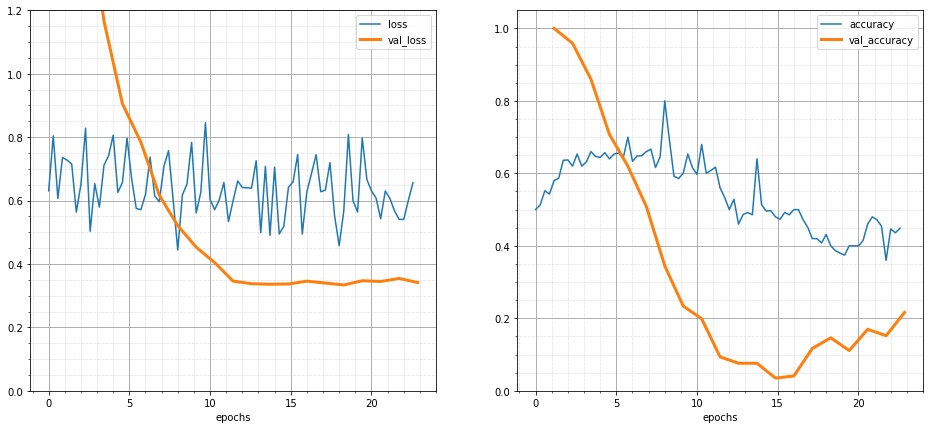

398/398 [==============================] - 1s 1ms/sample - loss: 0.6256 - accuracy: 0.4523 - val_loss: 0.3416 - val_accuracy: 0.2164


In [72]:
lossFunc = tf.keras.losses.CategoricalCrossentropy()

seqModel = tf.keras.Sequential(
[#featureLayer,
 tf.keras.layers.Input(shape=(30,)),
 tf.keras.layers.Dense(100),
 tf.keras.layers.Activation('relu'),    
 
 tf.keras.layers.Dense(60),
 tf.keras.layers.BatchNormalization(scale=False, center=True),
 tf.keras.layers.Activation('relu'),
 
 tf.keras.layers.Dense(50),
 tf.keras.layers.BatchNormalization(scale=False, center=True),
 tf.keras.layers.Activation('relu'),
 
 tf.keras.layers.Dense(10),
 tf.keras.layers.BatchNormalization(scale=False, center=True),
 tf.keras.layers.Activation('relu'),
 
 tf.keras.layers.Dense(2, activation='softmax')
]
)

testModel(seqModel, lossFunc)

In [33]:
# history = seqModel.fit(x=X, y=Y, epochs=EPOCHS, validation_split=0.3)

# # Plot the learning curves 
# plt.title('Learning curves')
# plt.xlabel('Epoch')
# plt.ylabel('Cross Entropy')
# plt.plot(history.history['loss'], label='Train')
# plt.plot(history.history['val_loss'], label='Val')
# plt.legend()
# plt.show()